<a href="https://colab.research.google.com/github/vadhri/ai-notebook/blob/main/aml/extraction/asmi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import base64
import numpy as np
import matplotlib.pyplot as plt
import torch

from datasets import Dataset, DatasetDict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from transformers import AutoModelForSequenceClassification, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [ ]:
df = pd.read_csv("./data/amsi/defender_data.csv", header=0, skiprows=lambda x: x % 10 != 0)
df = df.dropna().reset_index(drop=True)

df.head()

,name,hash,label,content
0,startChocolatey.ps1,764b29980e305e696aad2f7c9b82f6c0,Scan result is 1. IsMalware: 0,w6/Cu8K/PCMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIy...
1,common.ps1,f25c874cc9cee26ad8fe9f8aa3aa5da7,Scan result is 1. IsMalware: 0,ZnVuY3Rpb24gQWRkT3JVcGRhdGUtUmVmZXJlbmNlKCRzY3...
2,EntityFramework.psm1,27653f77dc9b0ca49f0f5603bb9eb515,Scan result is 1. IsMalware: 0,IyBDb3B5cmlnaHQgKGMpIE1pY3Jvc29mdCBDb3Jwb3JhdG...
3,uninstall.ps1,35bbf24389cc8bd2d8dcea9766ffd1e9,Scan result is 1. IsMalware: 0,cGFyYW0oJGluc3RhbGxQYXRoLCAkdG9vbHNQYXRoLCAkcG...
4,child-powershell.ps1,d83bf1333ff4979fbb4201261d7ce267,Scan result is 1. IsMalware: 0,cGFyYW0oCglbc3RyaW5nXSAkRGFkCikKCldyaXRlLU91dH...


In [ ]:
df["content"] = df["content"].apply(lambda x: base64.b64decode(x).decode())
df["label"] = df["label"].apply(lambda x: int(x.split("IsMalware: ")[-1]))
df.head()

,name,hash,label,content
0,startChocolatey.ps1,764b29980e305e696aad2f7c9b82f6c0,0,ï»¿<##########################################...
1,common.ps1,f25c874cc9cee26ad8fe9f8aa3aa5da7,0,function AddOrUpdate-Reference($scriptsFolderP...
2,EntityFramework.psm1,27653f77dc9b0ca49f0f5603bb9eb515,0,# Copyright (c) Microsoft Corporation. All ri...
3,uninstall.ps1,35bbf24389cc8bd2d8dcea9766ffd1e9,0,"param($installPath, $toolsPath, $package, $pro..."
4,child-powershell.ps1,d83bf1333ff4979fbb4201261d7ce267,0,"param(\n\t[string] $Dad\n)\n\nWrite-Output ""He..."


In [ ]:
print("number of samples labelled as malware",sum(df['label']))

number of samples labelled as malware 105


In [ ]:
df.describe(include="all")

,name,hash,label,content
count,38180,38180,38180.00000,38180
unique,18787,23600,NaN,23600
top,install.ps1,a418a8cb99789772d6d148d32f1d7b6c,NaN,function Get-Checksum($file) {\n $cryptoPro...
freq,3894,836,NaN,836
mean,NaN,NaN,0.00275,NaN
std,NaN,NaN,0.05237,NaN
min,NaN,NaN,0.00000,NaN
25%,NaN,NaN,0.00000,NaN
50%,NaN,NaN,0.00000,NaN
75%,NaN,NaN,0.00000,NaN


In [ ]:
interesting = ["content", "label", "name"] # add more columns
df[interesting].head()

,content,label,name
0,ï»¿<##########################################...,0,startChocolatey.ps1
1,function AddOrUpdate-Reference($scriptsFolderP...,0,common.ps1
2,# Copyright (c) Microsoft Corporation. All ri...,0,EntityFramework.psm1
3,"param($installPath, $toolsPath, $package, $pro...",0,uninstall.ps1
4,"param(\n\t[string] $Dad\n)\n\nWrite-Output ""He...",0,child-powershell.ps1


In [ ]:
vectorizer = TfidfVectorizer(stop_words="english", min_df=0.001, ngram_range=(1, 2))
vec = vectorizer.fit(df["content"])

word_doc_matrix = vec.transform(df["content"])
word_doc_matrix

<38180x29607 sparse matrix of type '<class 'numpy.float64'>'
	with 9339194 stored elements in Compressed Sparse Row format>

In [ ]:
pca = PCA(
    n_components=2
)  # 2 components because we're going to create a 2 dimensional plot
pca_data = pca.fit_transform(word_doc_matrix.toarray())
print("[+] Done")

[+] Done


In [ ]:
embedded_content = TSNE(
    n_components=2, # again, 2 components for 2d plotting

    # Set the perplexity hyperparameter (affects the clustering behavior)
    perplexity=50, # this is the most significant hyperparameter. Feel free to adjust and see how it changes the shape

    # Set the learning rate to "auto" (adaptive learning rate)
    learning_rate="auto",

    # Use the cosine metric for distance calculations
    metric="cosine",

    # Initialize the embedding to be random
    init="random",

    # parallelize all available cores
    n_jobs=-1,

).fit_transform(word_doc_matrix)

print("[+] Done")

[+] Done


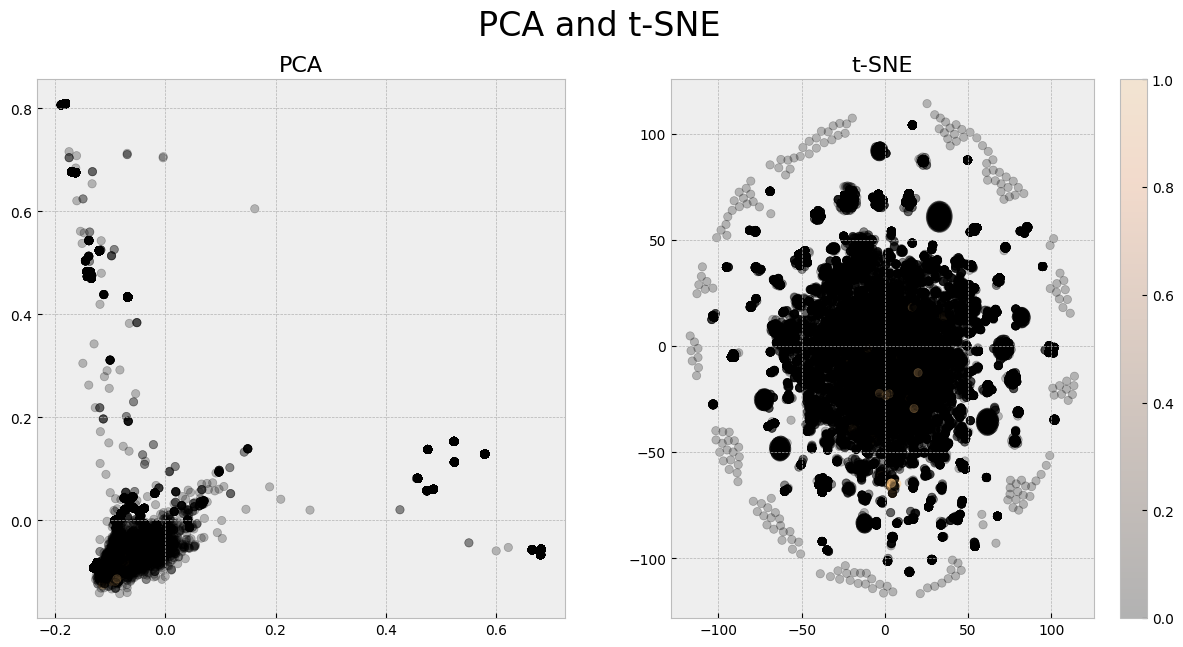

In [ ]:
with plt.style.context("bmh"):
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    ax0 = ax[0].scatter(
        x=pca_data[:, 0],
        y=pca_data[:, 1],
        c=df["label"],
        cmap="copper",
        alpha=0.25,
    )
    ax[0].set_title("PCA", fontsize=16)
    ax1 = ax[1].scatter(
        x=embedded_content[:, 0],
        y=embedded_content[:, 1],
        c=df["label"],
        cmap="copper",
        alpha=0.25,
    )
    ax[1].set_title("t-SNE", fontsize=16)
    fig.colorbar(ax1)
    fig.suptitle("PCA and t-SNE", fontsize=24)
plt.show()

In [ ]:
random_script = 13

print(f"Raw email:\n{df.iloc[random_script]['content']}")
print(f"Processed email:\n{vec.build_analyzer()(df.iloc[random_script]['content'])}")

Raw email:

function Invoke-CredentialsPhish
{
<#
.SYNOPSIS
Nishang script which opens a user credential prompt.

.DESCRIPTION
This payload opens a prompt which asks for user credentials and does not go away till valid local or domain credentials are entered in the prompt.

.EXAMPLE
PS > Invoke-CredentialsPhish

.LINK
http://labofapenetrationtester.blogspot.com/
https://github.com/samratashok/nishang
#>

[CmdletBinding()]
Param ()

    $ErrorActionPreference="SilentlyContinue"
    Add-Type -assemblyname system.DirectoryServices.accountmanagement 
    $DS = New-Object System.DirectoryServices.AccountManagement.PrincipalContext([System.DirectoryServices.AccountManagement.ContextType]::Machine)
    $domainDN = "LDAP://" + ([ADSI]"").distinguishedName
    while($true)
    {
        $credential = $host.ui.PromptForCredential("Credentials are required to perform this operation", "Please enter your user name and password.", "", "")
        if($credential)
        {
            $creds = $crede

In [ ]:
# this is the model we want to train
model_name = "bert-base-uncased"

# add the preprocessor
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.8/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
max_len = 512

encodings = tokenizer(df['content'].tolist(), truncation=True, padding="max_length", max_length=max_len)

# Extract input ids, masks and convert to tensors
input_ids = torch.tensor(encodings.input_ids)
attention_masks = torch.tensor(encodings.attention_mask)

In [ ]:
# provided code
labels = torch.tensor(df['label'].values).float()

# your code here
threshold = 100

labels = (labels >= threshold).long()

# Create DatasetDict
hf_dataset = Dataset.from_dict(
    {
        'input_ids': input_ids.tolist(),
        'attention_masks': attention_masks.tolist(),
        'labels': labels.tolist()
    }
)


In [ ]:
train_test = hf_dataset.train_test_split(test_size=0.2)
train_dataset = train_test['train']
test_dataset = train_test['test']

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
)

# Create a Trainer
trainer = Trainer(
    model=model,                     # the instantiated 🤗 Transformers model to be trained
    args=training_args,              # training arguments, defined above
    train_dataset=train_dataset,     # training dataset
    eval_dataset=test_dataset        # eval dataset
)

# Train the model
trainer.train()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/usr/local/lib/python3.8/dist-packages/accelerate/accelerator.py:447: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Step,Training Loss
100,0.231100
200,0.001700
300,0.000500
400,0.000200
500,0.000100
600,0.000100
700,0.000100
800,0.000000
900,0.000000
1000,0.000000


TrainOutput(global_step=5727, training_loss=0.004089150538228267, metrics={'train_runtime': 2184.479, 'train_samples_per_second': 41.947, 'train_steps_per_second': 2.622, 'total_flos': 2.410939222474752e+16, 'train_loss': 0.004089150538228267, 'epoch': 3.0})

In [ ]:
eval_results = trainer.evaluate()

print(f"Validation results: {eval_results}")

Validation results: {'eval_loss': 1.3153921827324666e-06, 'eval_runtime': 52.3168, 'eval_samples_per_second': 145.957, 'eval_steps_per_second': 2.294, 'epoch': 3.0}


In [ ]:
model.eval() # we did just eval. But just in case...you can't be too careful.

example = tokenizer("Please click on this link", return_tensors="pt") # insert your own string to test

with torch.no_grad():
    outputs = model(**example.to(device))

predictions = outputs.logits.argmax(-1)
print(f"Prediction (0/1):\n---------------\n{predictions.item()}\n")

Prediction (0/1):
---------------
0

